## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

def calibrate(nx=9, ny=6, debug=False):
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if not ret: continue

        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        objpoints.append(objp)
        imgpoints.append(corners)
        
        if debug:
            plt.imshow(img)
            plt.show()
                
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    dist_pickle = { "mtx": mtx, "dist": dist }

    with open("wide_dist_pickle.p", "wb") as f:
        pickle.dump(dist_pickle, f)

    if debug:
        for fname in images:
            img = cv2.imread(fname)
            plt.imshow(cv2.undistort(img, mtx, dist, None, mtx))
            plt.show()
            
    return mtx, dist

mtx, dist = calibrate()

## And so on and so forth...

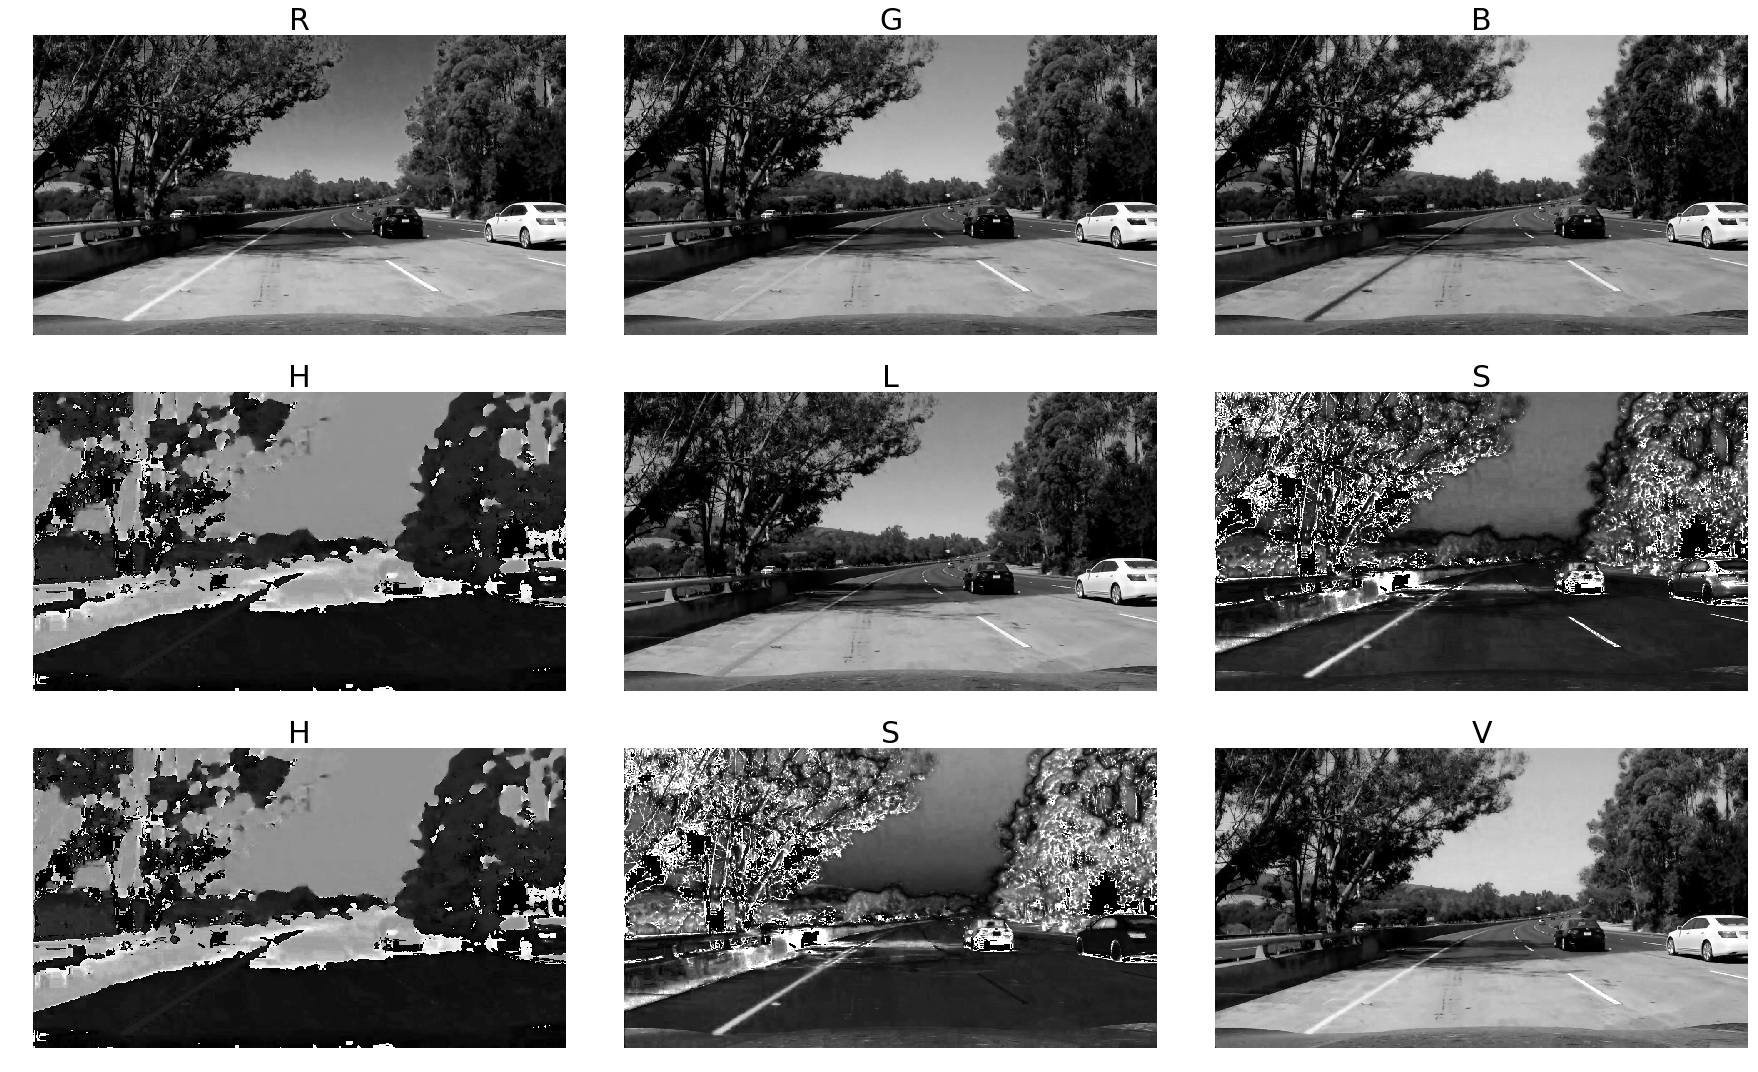

In [14]:
def convert_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def convert_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

def convert_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

img = cv2.imread('./test_images/test5.jpg')
fig, axs = plt.subplots(3, 3, figsize=(25, 15))
fig.subplots_adjust(hspace=.2, wspace=.001)
axs = axs.ravel()

labels = ['R', 'G', 'B', 'H', 'L', 'S', 'H', 'S', 'V']
channels = cv2.split(convert_rgb(img))
channels.extend(cv2.split(convert_hls(img)))
channels.extend(cv2.split(convert_hsv(img)))

for i in range(len(labels)):
    axs[i].imshow(channels[i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(labels[i], size=30)
    
plt.tight_layout()

In [23]:
def filter_color(img, display=False):
    white =  cv2.inRange(img, (0, 210, 0), (255, 255, 255))
    yellow = cv2.inRange(img, (15, 30, 115), (35, 205, 255))
    filter_ = cv2.bitwise_or(white, yellow)
    if display:
        plt.imshow(filter_, cmap='gray')
        plt.axis('off')
    return filter_

def gaussian_blur(img, kernel=(3,3), display=False):
    gaussian = cv2.GaussianBlur(img, kernel, 0)
    if display:
        plt.imshow(gaussian, cmap='gray')
        plt.axis('off')
    return gaussian

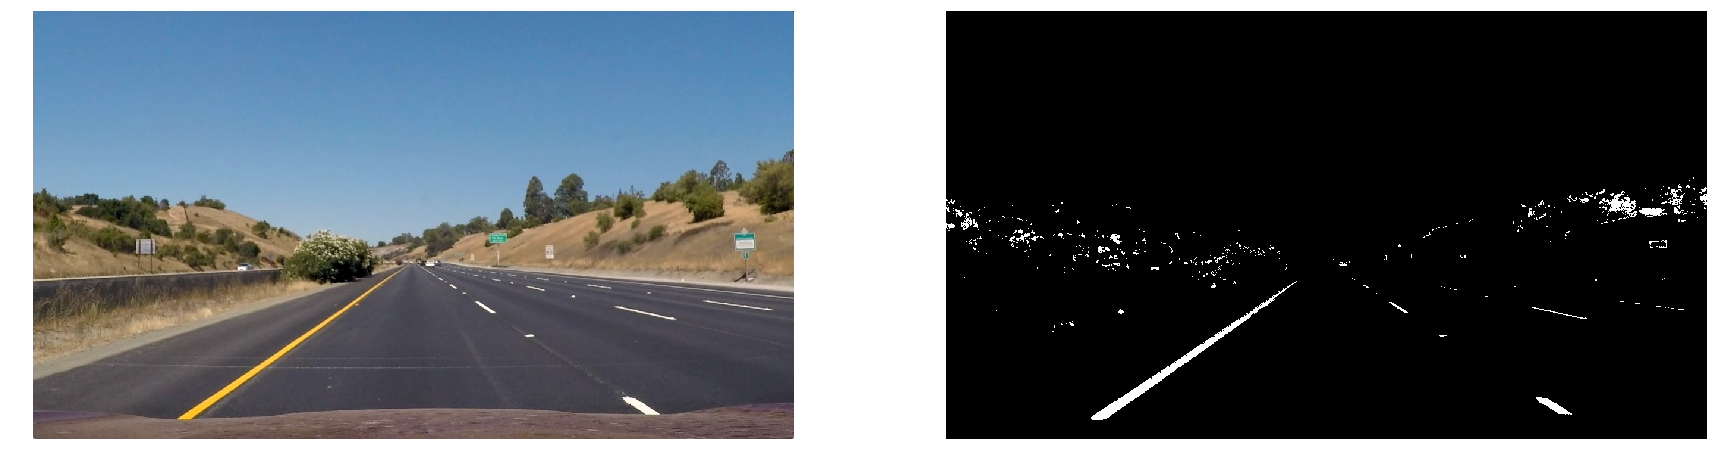

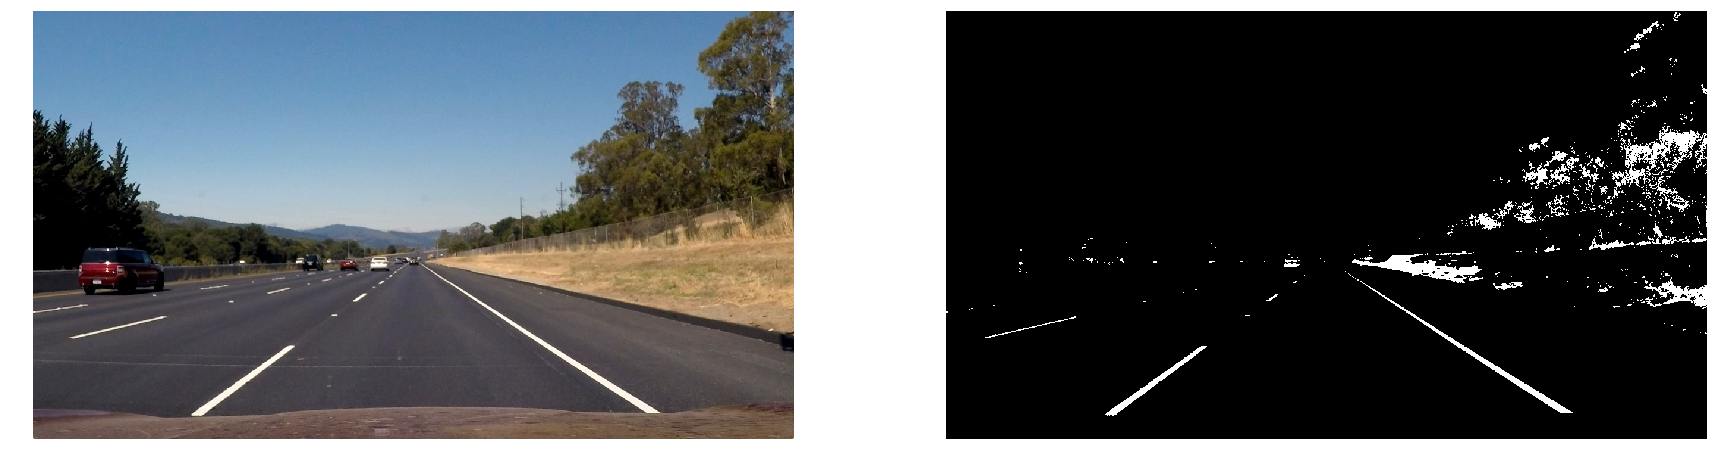

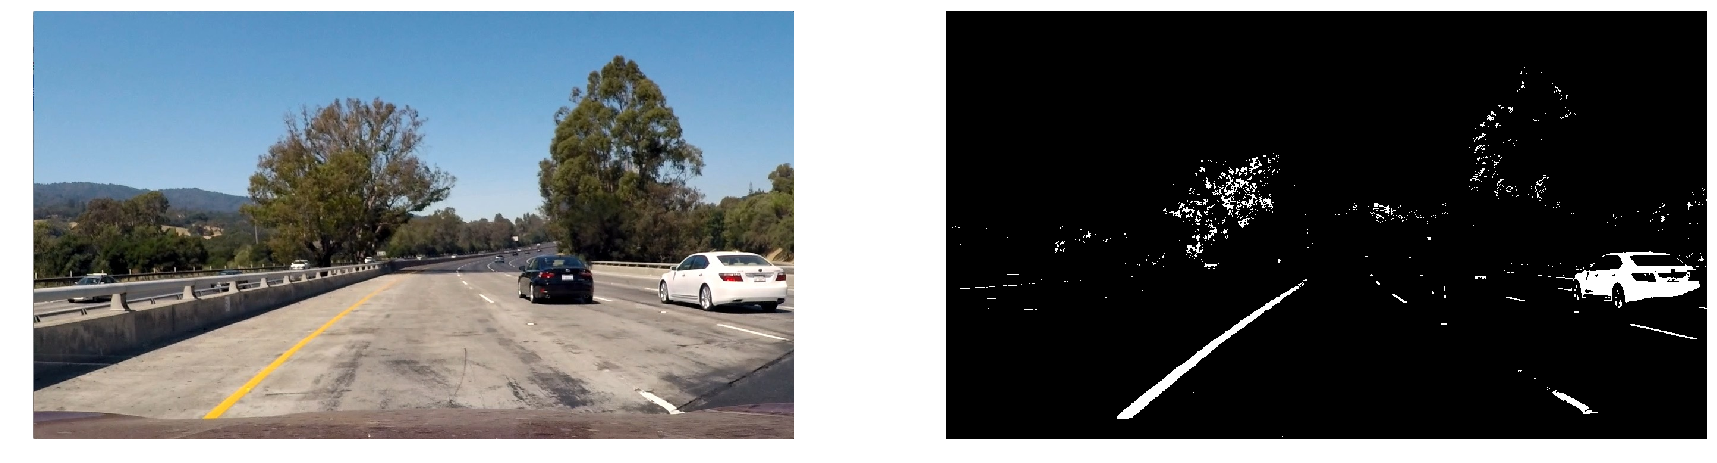

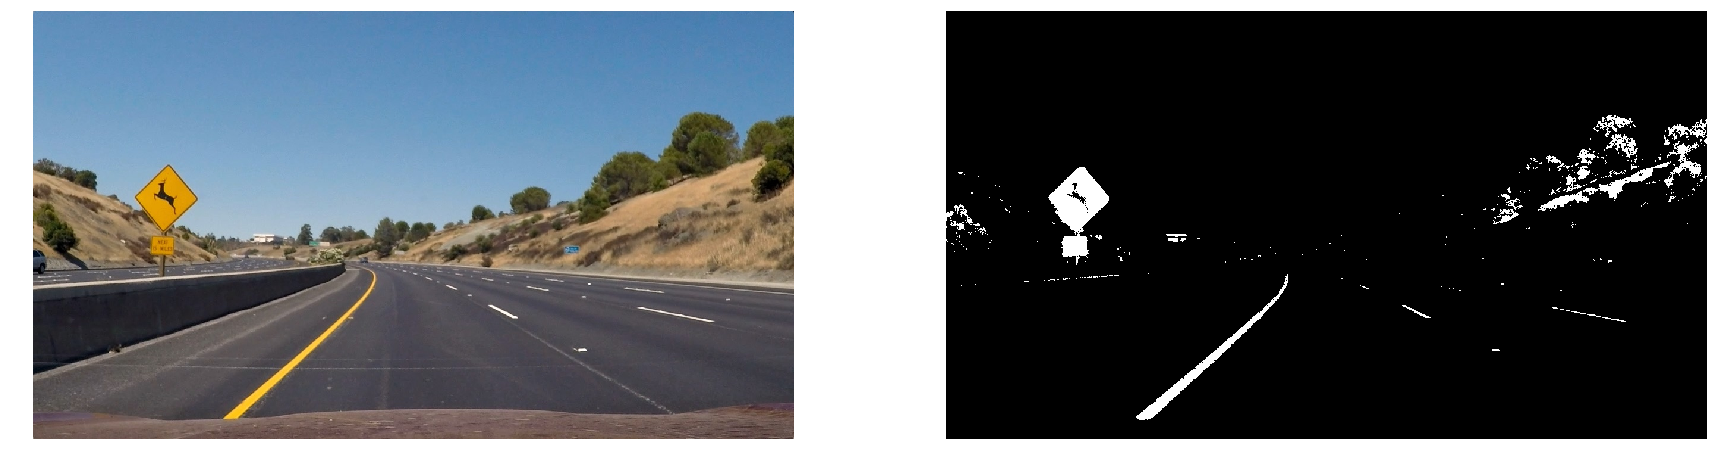

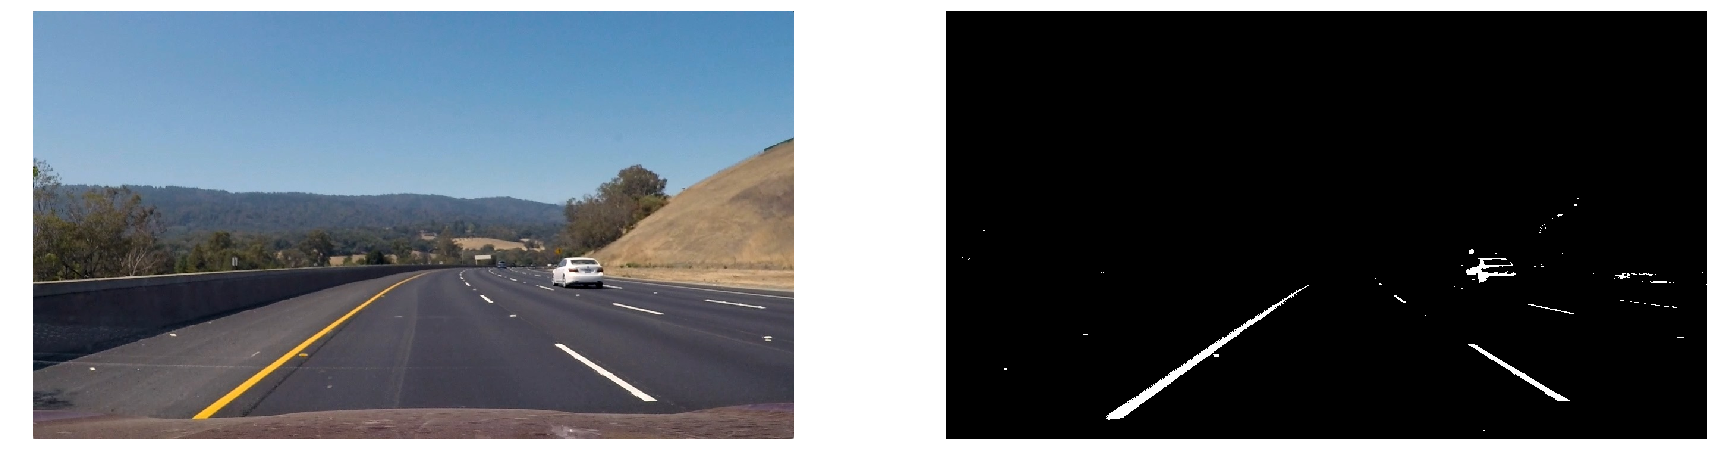

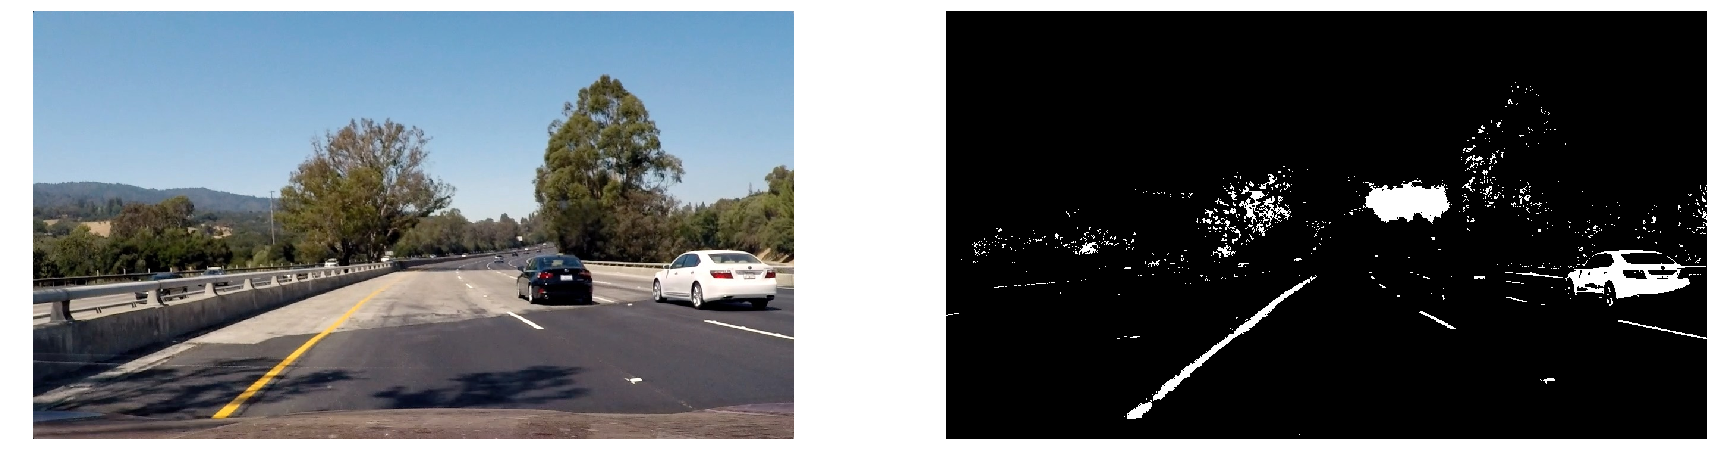

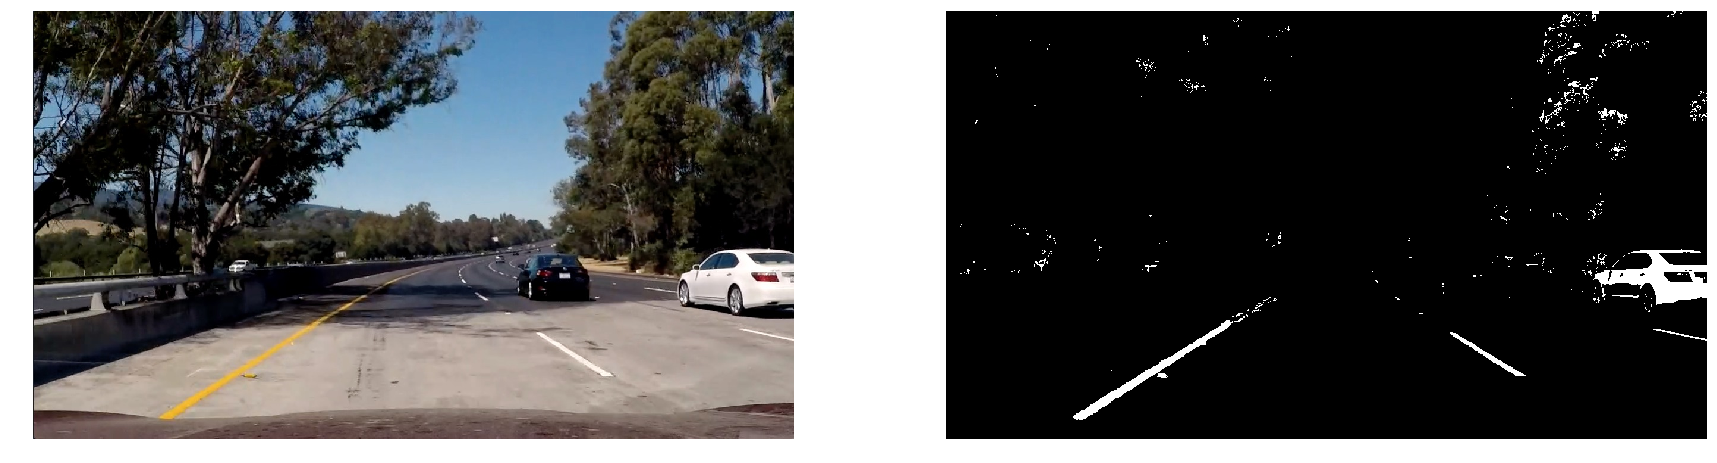

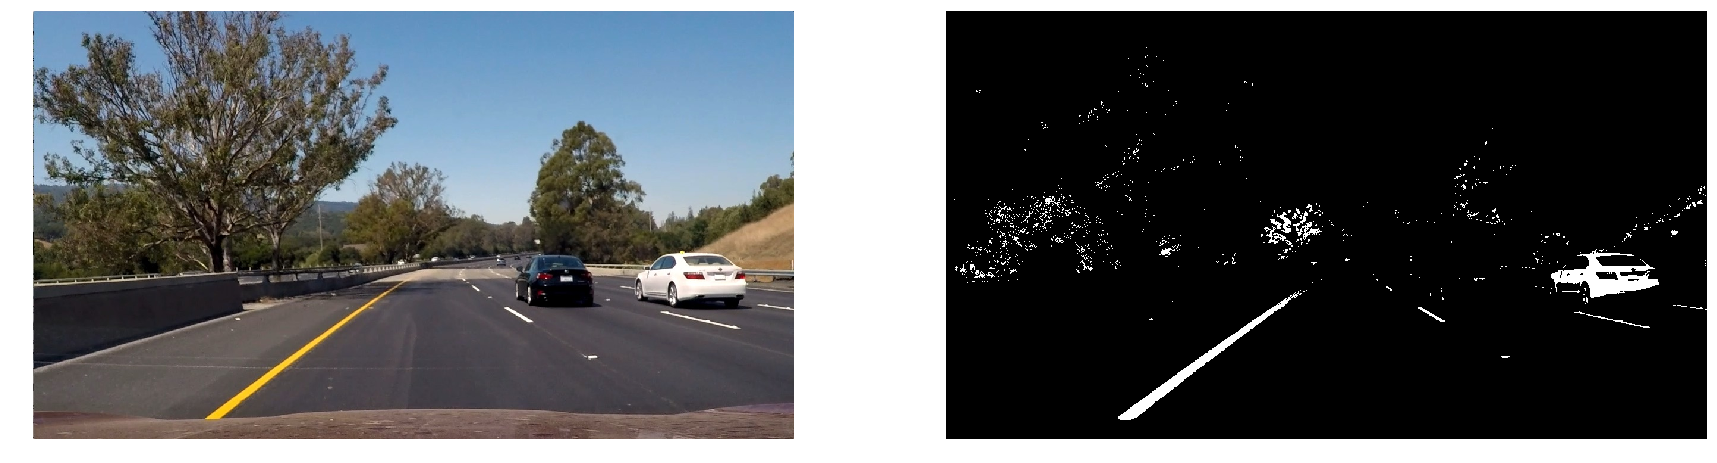

In [25]:
import glob

files = glob.glob('test_images/*.jpg')
for i, file_ in enumerate(files):
    img = cv2.imread(file_)
    plt.figure(figsize=(30, 80))
    plt.subplot(len(files), 2, 2*i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.subplot(len(files), 2, 2*i+2)
    _ = filter_color(convert_hls(img), display=True)

In [26]:
def mag_threshold(gray, sobel_kernel=3, thresh=(0, 255)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobel = (sobelx**2 + sobely**2)**0.5
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    
    return binary_output

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    gradient = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    binary_output = np.zeros_like(gradient)
    binary_output[(gradient > thresh[0]) & (gradient < thresh[1])] = 1

    return binary_output

def sobel_threshold(gray, sobel_kernel=3, mag_thresh=(0, 255), dir_thresh=(0, np.pi/2), display=False):
    mag = mag_threshold(gray, sobel_kernel, mag_thresh)
    dir_ = dir_threshold(gray, sobel_kernel, dir_thresh)
    ret = np.zeros_like(gray)
    ret[(mag == 1) & (dir_ == 1)] = 1
    
    if display:
        plt.imshow(ret, cmap='gray')
        
    return ret

In [27]:
def warp(img, mtx, dist, display=False):
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    w = undistorted.shape[1]
    h = undistorted.shape[0]
    src = np.float32([[603, 450],[w-603, 450], [w-280, h], [280, h]])
    dst = np.float32([[300, 0], [w-300, 0], 
                      [w-300, h],[300, h]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undistorted, M, (w, h), flags=cv2.INTER_LINEAR)
    
    if display:
        plt.imshow(warped, cmap='gray')
        plt.show()
        
    return warped

def find_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    margin = 100
    minpix = 50

    window_height = np.int(binary_warped.shape[0]//nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped, display=False):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    if display:
        plt.imshow(out_img)
        plt.show()

    return out_img

def process(img, display=False):
    hls = convert_hls(img)
    filter_ = filter_color(hls)
    warped = warp(filter_, mtx, dist)
    gaussian = gaussian_blur(warped, kernel=(5,5), display=display)
    sobel = sobel_threshold(gaussian, sobel_kernel=3, mag_thresh=(20, 100), dir_thresh=(0, np.pi/2))

    return fit_polynomial(sobel, display)

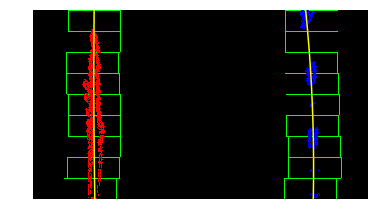

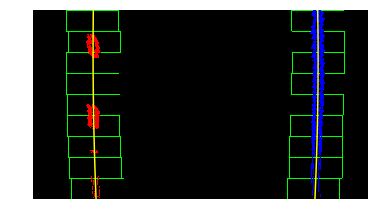

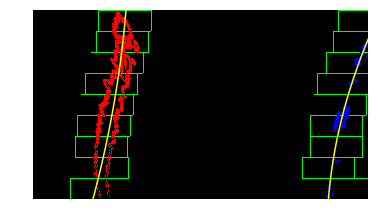

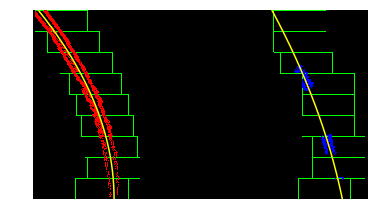

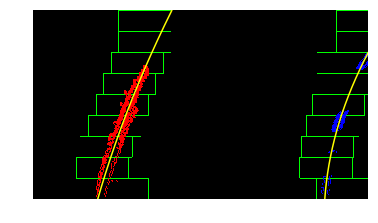

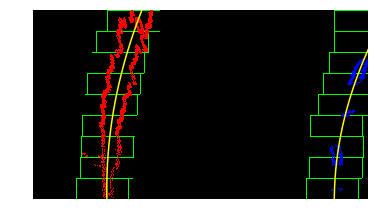

In [29]:
process(cv2.imread('./test_images/straight_lines1.jpg'), True)
process(cv2.imread('./test_images/straight_lines2.jpg'), True)
process(cv2.imread('./test_images/test1.jpg'), True)
process(cv2.imread('./test_images/test2.jpg'), True)
process(cv2.imread('./test_images/test3.jpg'), True)
_ = process(cv2.imread('./test_images/test4.jpg'), True)

In [32]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [39]:
def process_image(image):
    return process(image, True)

In [42]:
project_output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

OSError: [WinError 6] ハンドルが無効です。